# Visual Question Answering in MXNET Gluon

This is a notebook for implementing visual question answering using MXNET Gluon.

This notebook is based on:

<a href="https://arxiv.org/pdf/1606.01847.pdf">"Multimodal Compact Bilinear Pooling for Visual Question Answering and Visual Grounding"</a>, Akira Fukui, Dong Huk Park, Daylen Yang, Anna Rohrbach, Trevor Darrell and Marcus Rohrbach, EMNLP 2016


## Table of Content:
* [VQA Task](#vqatask)
* [VQA Dataset](#dataset)
* [Feature Extraction](#feature)
* [Pooling methods](#pooling)
* [Models](#models)
* [Data IO](#dataio)
* [Training](#train)
* [Testing](#test)

## VQA Task <a class="anchor" id="vqatask"></a>

Visual question answering(VQA) is a task focusing on providing a natural language answer given any image and any open-ended question. This task requires a deep understanding and reasoning of the image combined with the question: a joint representation of both visual and textual input.


![](img/pizza.png )


## VQA Dataset  <a class="anchor" id="dataset"></a>

__VQA dataset v1__ is first released by Antol et. al in this <a href="https://arxiv.org/pdf/1505.00468v6.pdf">paper</a>. Based on the type of images: real images and abstract scenes, they have two different dataset. However, due to the inherent structure in our world and bias in language, the learning process is biased. In other words, a specific question tends to have a specific answer regardless of the image. Thus, Goyal et. al. release <a href="https://arxiv.org/pdf/1505.00468v6.pdf">VQA dataset v2</a>. They prepare similar images with same questions but leads to different answers.

Johnson et. al. introduce Compositional Language and Elementary Visual Reasoning(__CLEVR__) diagnostic <a href="https://arxiv.org/abs/1612.06890">dataset</a> which focuses more on reasoning. Strub et. al. propose a <a href="https://arxiv.org/abs/1611.08481">__two-player guessing game__</a>: guess a target in a given image with a sequential questions and answers. This requires both visual question answering and spatial reasoning.

The <a href="https://arxiv.org/pdf/1505.00468v6.pdf">Task Driven Image Understanding Challenge dataset</a>(__TDIUC__) contains over 1.6 million questions organized into 12 different categories. It contains images and annotations from MSCOCO and Visual genome. The key differences between TDIUC and VQA v1/v2 dataset are: (1)Categorized questions: Each question belongs to one of the 12 categories. This helps us have a task-oriented evaluation. Besides simple accuracy, we can also calculate arithmetic and harmonic means across all per question-type accuracies. 
(2)Absurd questions: Questions that are totally irrelevant to the image. In this way, it force an algorithm to determine if a question is valid. This also helps to balance the dataset.


In this notebook, we will use VQA dataser v1 for demostration. You can download the VQA1.0 dataset from <a href="http://www.visualqa.org/vqa_v1_download.html">VQA</a> website. 

You need to preprocess the data:

(1) Extract the samples from original json files. 

(2) Filter the samples giving top k answers(k can be 1000, 2000...). This will make the prediction easier.

## Feature Extraction <a class="anchor" id="feature"></a>

Usually people use pretrained models to extract features from the image and question.

__Image pretrained model__: 

<a href="https://arxiv.org/abs/1409.1556">VGG</a>: A key aspect of VGG was to use many convolutional blocks with relatively narrow kernels, followed by a max-pooling step and to repeat this block multiple times. 

<a href="https://arxiv.org/abs/1512.03385">Resnet</a>: It is a residual learning framework to ease the training of networks that are substantially deep. It reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

__Question pretrained model__: 

<a href="https://code.google.com/archive/p/word2vec/">Word2Vec</a>: The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The model contains 300-dimensional vectors for 3 million words and phrases. 

<a href="https://nlp.stanford.edu/projects/glove/">Glove</a>: Similar to Word2Vec, it is a word embedding dataset. It contains 100/200/300-dimensional vectors for 2 million words.

<a href="https://arxiv.org/abs/1506.06726">Skipthought</a>: This is an encoder-decoder model that tries to reconstruct the surrounding sentences of an encoded passage. Sentences that share semantic and syntactic properties are thus mapped to similar vector representations. Different from the previous two model, this is a sentence based model.

<a href="https://research.google.com/pubs/pub45610.html">GNMT encoder</a>: We propose using the encoder of google neural machine translation system to extract the question features. 

__We will discuss about how to extract the features <a href="extract-feature.ipynb">here</a> in details.__

## Pooling Methods <a class="anchor" id="pooling"></a>

After we extract the features, information of each modality are then combined together, using concatenation, element-wise product or sum operations.

Pooling methods are widely used in visual tasks to combine information for various streams into one final feature representation. It inherently can be applied to VQA task. Common pooling methods are average pooling and bilinear pooling. Bilinear pooling requires taking the outer product between two features. However the high dimensional result makes it hard to be applied to huge real image dataset. Thus, different compact pooling methods are proposed to solve this problem.

In the following notebook, we will illustrate two different models:(1) Concatenation (2) Multimodel compact bilinear pooling.

__We will introduce attention model in this <a href="Attention-VQA-gluon.ipynb">notebook</a>.__

## Models <a class="anchor" id="models"></a>

We define our model with <a href="https://mxnet.incubator.apache.org/api/python/gluon.html">MXNET Gluon</a>. gluon.Block is the basic building block of models. If any operator is not defined under gluon, you can use mxnet.ndarray operators to subsititude. 

In [1]:
from __future__ import print_function
import numpy as np
import mxnet as mx
import mxnet.ndarray as F
import mxnet.contrib.ndarray as C
import mxnet.gluon as gluon
from mxnet.gluon import nn
from mxnet import autograd
import bisect
from IPython.core.display import display, HTML
import logging
logging.basicConfig(level=logging.INFO)
import os
from mxnet.test_utils import download
import json
from IPython.display import HTML, display

In [2]:
# Some parameters we are going to use
batch_size = 64
#ctx = mx.gpu(1)
ctx = mx.cpu()
compute_size  = batch_size
out_dim = 10000
gpus = 1

In the __first model__, we will concatenate the image and question features and use multilayer perception(MLP) to predict the answer.

In [3]:
class Net1(gluon.Block):
    def __init__(self, **kwargs):
        super(Net1, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        z = F.concat(x1,x2,dim=1)
        z = self.fc1(z)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z


In the __second model__, instead of linearly combine the image and text features, we use count sketch to estimate the outer product of the image and question features. It is also named as multimodel compact bilinear pooling(MCB). This method was proposed in <a href="https://arxiv.org/abs/1606.01847">Multimodal Compact Bilinear Pooling for VQA</a>. 

Given a vector $a \in \mathcal{R}^n$, random hash function $h \in \mathcal{R}^n$: $[n] \to [b]$ and binary variable $s \in \mathcal{R}^n$: $[n] \to \pm 1$, the count sketch operator $\psi(a,h,s) \in \mathcal{R}^b$ is:

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \psi(a,h,s)[j] = \sum_{h[i] = j}s[i]a[i], \quad j \in {1,\cdots,b}$

Let $x$ and $y$ be two separate feature vectors, and their bilinear pooling feature be $x \otimes y$, then:

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \psi(x \otimes y, h,s) = \psi(x,h,s) \star \psi(y,h,s)$

where $\star$ is the convolution operator. This can further be simplified by using FFT properties: convolution in time domain equals to elementwise product in frequency domain. We show the procedure below:


![](img/mcb.png )


One improvement we made is adding ones vectors to each features before count sketch. The intuition is: given input vectors $x,y$, estimating outer product between $[x,1s]$ and $[y, 1s]$ gives us information more than just $x \otimes y$. It also contains information of $x$ and $y$.

In [4]:
class Net2(gluon.Block):
    def __init__(self, **kwargs):
        super(Net2, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        text_ones = F.ones((batch_size/gpus, 2048),ctx = ctx)
        img_ones = F.ones((batch_size/gpus, 1024),ctx = ctx)
        text_data = F.Concat(x1, text_ones,dim = 1)
        image_data = F.Concat(x2,img_ones,dim = 1)
        # Initialize hash tables
        # Random seed to ensure we have same hash function for all samples
        np.random.seed(0)
        S1 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        np.random.seed(0)
        H1 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        np.random.seed(1)
        S2 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        np.random.seed(1)
        H2 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        # Count sketch
        cs1 = C.count_sketch( data = image_data, s=S1, h = H1 ,name='cs1',out_dim = out_dim) 
        cs2 = C.count_sketch( data = text_data, s=S2, h = H2 ,name='cs2',out_dim = out_dim) 
        fft1 = C.fft(data = cs1, name='fft1', compute_size = compute_size) 
        fft2 = C.fft(data = cs2, name='fft2', compute_size = compute_size) 
        c = fft1 * fft2
        ifft1 = C.ifft(data = c, name='ifft1', compute_size = compute_size) 
        # MLP
        z = self.fc1(ifft1)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z


## Data IO <a class="anchor" id="dataio"></a>

MXNET requires a data iterator to feed in the samples to the model.

In [5]:
from VQAtrainIter import VQAtrainIter

The function is defined in __VQAtrainIter.py__.

The inputs of the data iterator are extracted image and question features. At each step, the data iterator will return a data batch list: question data batch and image data batch. 

We need to seperate the data batches by the length of the input data because the input questions are in different lengths. The $buckets$ parameter defines the max length you want to keep in the data iterator. Here since we already used pretrained model to extract the question feature, the question length is fixed as the output of the pretrained model.

The $layout$ parameter defines the layout of the data iterator output. "N" specify where is the data batch dimension is.

$reset()$ function is called after every epoch. $next()$ function is call after each batch.

Here we will use subset of VQA v1 dataset in this tutorial. We extract the image feature from ResNet-152, text feature from GNMT encoder. We have 21537 training samples and 1044 validation samples in this tutorial. Image feature is a 2048-dim vector. Question feature is a 1024-dim vector. 

In [6]:
# Download the dataset
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                 'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}

train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_q),overwrite=True)
    download(url_format.format(train_i),overwrite=True)
    download(url_format.format(train_a),overwrite=True)
if not os.path.exists(val_q):
    logging.info('Downloading validation dataset.')
    download(url_format.format(val_q),overwrite=True)
    download(url_format.format(val_i),overwrite=True)
    download(url_format.format(val_a),overwrite=True)


In [7]:
layout = 'NT'
bucket = [1024]

train_question = np.load(train_q)['x']
val_question = np.load(val_q)['x']
train_ans = np.load(train_a)['x']
val_ans = np.load(val_a)['x']
train_img = np.load(train_i)['x']
val_img = np.load(val_i)['x']

print("Total training sample:",train_ans.shape[0])   
print("Total validation sample:",val_ans.shape[0])   

data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout) 


Total training sample: 21537
Total validation sample: 1044


## Training  <a class="anchor" id="train"></a>

We __initialize the parameters__, __define loss, evaluation metrics and optimizer__ as follows:

In [8]:
net = Net1()
#net = Net2()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            output = net(data)
        
        metric.update([label], [output])
    return metric.get()[1]


In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

After the initializations, we can start the training. It takes one batch a time. After we run over all batches(one epoch), we calculate the training/validation accuracy and save the network parameters if the validation accuracy is higher than the previous one. 

In [11]:
epochs = 10
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
        #if i % 200 == 0:
        #    print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))   
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Eval_acc %s" % (e, moving_loss, train_accuracy, eva_accuracy))
    if eva_accuracy > best_eva:
            best_eva = eva_accuracy
            logging.info('Best validation acc found. Checkpointing...')
            net.save_params('vqa-mlp-%d.params'%(e))


INFO:root:Best validation acc found. Checkpointing...


Epoch 0. Loss: 2.94325249822, Train_acc 0.445534446023, Eval_acc 0.384765625


INFO:root:Best validation acc found. Checkpointing...


Epoch 1. Loss: 2.00672398202, Train_acc 0.483775745739, Eval_acc 0.442807404891


INFO:root:Best validation acc found. Checkpointing...


Epoch 2. Loss: 1.64857072872, Train_acc 0.517578125, Eval_acc 0.481336805556


INFO:root:Best validation acc found. Checkpointing...


Epoch 3. Loss: 1.33320239985, Train_acc 0.551225142045, Eval_acc 0.515741604478


INFO:root:Best validation acc found. Checkpointing...


Epoch 4. Loss: 1.12062701052, Train_acc 0.582794744318, Eval_acc 0.549607180478


INFO:root:Best validation acc found. Checkpointing...


Epoch 5. Loss: 1.05326851985, Train_acc 0.609456380208, Eval_acc 0.581116272523


INFO:root:Best validation acc found. Checkpointing...


Epoch 6. Loss: 0.800970615745, Train_acc 0.632894937094, Eval_acc 0.607833059211


INFO:root:Best validation acc found. Checkpointing...


Epoch 7. Loss: 0.730079422974, Train_acc 0.653958407315, Eval_acc 0.631401209677


INFO:root:Best validation acc found. Checkpointing...


Epoch 8. Loss: 0.644547770061, Train_acc 0.672037760417, Eval_acc 0.652459613347


INFO:root:Best validation acc found. Checkpointing...


Epoch 9. Loss: 0.537664141449, Train_acc 0.687650923295, Eval_acc 0.670662884736


## Testing  <a class="anchor" id="test"></a>

After the training loop over Net1 or Net2, we can try it on test data. Here we have 10 test samples. 

In [12]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']

if test and not os.path.exists(test_q):     
    logging.info('Downloading test dataset.')
    download(url_format.format(test_q_id),overwrite=True)
    download(url_format.format(test_q),overwrite=True)
    download(url_format.format(test_i_id),overwrite=True)
    download(url_format.format(test_i),overwrite=True)
    download(url_format.format(atoi),overwrite=True)
    download(url_format.format(text),overwrite=True)

if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']
    #atoi = np.load("atoi.json")['x']    

We pass the test data iterator to the trained model. The output is a list of predicted answers. 

In [13]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

We randomly select one sample to show the testing result.

In [14]:
idx = np.random.randint(10)
question = json.load(open(text))
print("Question:", question[idx])

Question: Is the bird looking at the camera?


INFO:root:Downloading training dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_images/COCO_test2015_000000504864.jpg into COCO_test2015_000000504864.jpg successfully


Image:


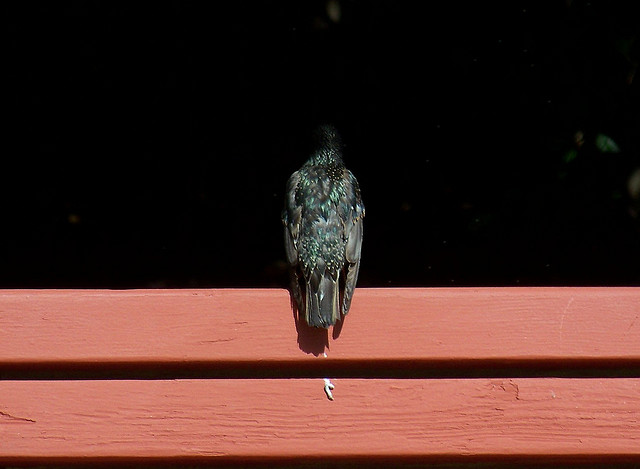

In [15]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
print("Image:")
Image(filename=image_name) 

In [16]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: no
